Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'} 

Train - R2:	0.987
Train - MAE:	0.087
Train - RMSE:	0.113
Train - Adjusted R2:	0.987

Test - R2:	0.683
Test - MAE:	0.440
Test - RMSE:	0.961
Test - Adjusted R2:	0.683


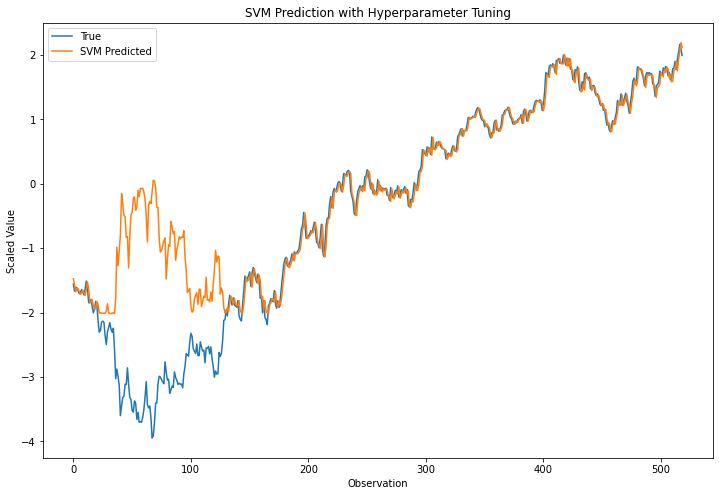

In [10]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Loading dataset
exchange_data = pd.read_csv('EURUSD.csv')
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

# Sorting data in ascending order
data_frame = ind_exchange_data.sort_index(axis=1, ascending=True)
data_frame = data_frame.iloc[::-1]
df = data_frame[["close"]]

# Splitting data into train and test sets
split_date = pd.Timestamp('01-01-2021')
train = df.loc[split_date:]
test = df.loc[:split_date]

# Standardizing data
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

# Creating features and labels
X_train = train_sc[:-1]
y_train = train_sc[1:].ravel()  # Flatten to fit SVR requirements

X_test = test_sc[:-1]
y_test = test_sc[1:].ravel()  # Flatten to fit SVR requirements

# Training Model
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Broader range including smaller values
    'epsilon': [0.01, 0.1, 0.2, 0.3],  # Adjusted range to find a better balance
    'kernel': ['rbf'],  # Using RBF kernel; you might limit to one kernel type initially for simplicity
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(SVR(), param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_, '\n')

# Training SVM model with the best parameters
svm_model = SVR(**grid_search.best_params_)
svm_model.fit(X_train, y_train)

y_pred_test = svm_model.predict(X_test)
y_train_pred = svm_model.predict(X_train)

# Calculating evaluation metrics
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(train_mse)
test_mse = metrics.mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(test_mse)

print("Train - R2:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("Train - MAE:\t{:0.3f}".format(metrics.mean_absolute_error(y_train, y_train_pred)))
print("Train - RMSE:\t{:0.3f}".format(rmse_train))
r2_train = r2_score(y_train, y_train_pred)
print("Train - Adjusted R2:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))

print("Test - R2:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))
r2_test = r2_score(y_test, y_pred_test)
print("Test - MAE:\t{:0.3f}".format(metrics.mean_absolute_error(y_test, y_pred_test)))
print("Test - RMSE:\t{:0.3f}".format(rmse_test))
print("Test - Adjusted R2:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

# Plotting true vs predicted values
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='SVM Predicted')
plt.title("SVM Prediction with Hyperparameter Tuning")
plt.xlabel('Observation')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()